In [1]:
import pickle
import matplotlib.pylab as plt
from matplotlib import cm

import numpy as np
from collections import defaultdict
from functools import partial
import scipy
import scipy.sparse.linalg
from datetime import datetime
import seaborn as sns

%matplotlib inline

In [2]:
%%javascript
// add equations numeration, but it is not quite smart solution
// because there is problem with several rendering of markdown (counter reseting)
// and execute all cells does not rerender markdown cells
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});

MathJax.Hub.Register.StartupHook("TeX AMSmath Ready", function () {
  var AMS = MathJax.Extension['TeX/AMSmath'];
  MathJax.InputJax.TeX.postfilterHooks.Add(function (data) {
    var jax = data.script.MathJax;
    jax.startNumber = AMS.startNumber;
    jax.eqLabels = AMS.eqlabels;
    jax.eqIDs = AMS.eqIDs;
  });
  MathJax.InputJax.TeX.prefilterHooks.Add(function (data) {
    var jax = data.script.MathJax;
    if (jax.startNumber != undefined) {
      AMS.startNumber = jax.startNumber;
      Object.keys(jax.eqLabels).forEach(function (x) {delete AMS.labels[x]});
      Object.keys(jax.eqIDs).forEach(function (x) {delete AMS.IDs[x]});
    }
  }, 1);
});

MathJax.Hub.Queue( ["resetEquationNumbers",MathJax.InputJax.TeX]);

<IPython.core.display.Javascript object>

# Restauration d'image à l'aide de l'ADMM

# 1. Altération d'une image

##  1.1 Flou de bougé

On utilisera tout au long du TP la scène présentée sur la figure 1. Il s'agit d'une image en niveaux de gris (normalisés entre 0 et 1) de taille 64 × 64.

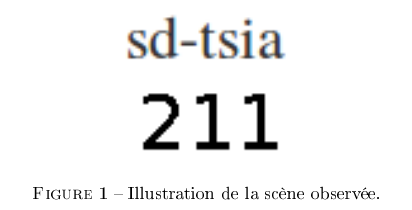

On suppose que l'on prend en photo la scène illustrée sur la figure 1. Lorsque l'on prend une photo, l'obturateur de l'appareil photo laisse passer la lumière durant un petit intervalle de temps. Si durant cet
intervalle de temps, l'appareil (ou la scène) bouge, cela entraîne le phénomène bien connu de la photo floue. On souhaiterait pouvoir restaurer l'image afin de la rendre le plus net possible. L'effet d'un flou de bougé peut s'exprimer comme une convolution par un filtre contenant l'information sur le mouvement de l'appareil photo lors de l'acquisition. La réponse spatiale de ce filtre est illustrée sur la figure 2.

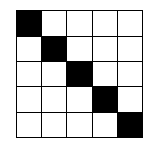
Figure 2 - Réponse spatiale du filtre représentant le mouvement de l'appareil photo ayant entraîné le flou de bougé.

## 1.2 Modélisation mathématique

On notera $X \in R^{K\times L}$ l'image 2D originale que l'on cherche à reconstruire, avec $K = L = 64$ pixels dans le cas de la scène observée présentée sur la figure 1. On notera $P = K \times L$ le nombre total de pixels dans l'image. De même $Y$ représente l'observation en 2D, i.e. l'image $X$ détériorée par le flou de bougé. On peut modéliser mathématiquement l'effet du flou de bougé sur l'image observée par l'équation :

$$
\begin{equation}
\mathbf{Y} = \mathcal{H} \star \mathbf{X} 
\end{equation}
$$

où $H \in R^{M \times N}$ est la réponse spatiale du filtre de flou de bougé. Dans le cas du filtre utilisé dans ce TP, illustré sur la figure 2, on a $M = N = 5$ pixels. On préférera utiliser la notation matricielle pour exprimer ce produit de convolution sur les images vectorisées :

$$ 
\begin{equation} 
y = \mathbf{H}x 
\end{equation} 
$$

où $\mathbf{H} \in R^{P \times P}$ est la matrice de convolution, traduisant l'opération de convolution par H après vectorisation de l'image.

## 1.3 Illustration

**Manipulation 1**

---

Toutes les données à utiliser dans ce TP sont stockées dans le fichier "data2018.pk" qui contient:
- 'original' : tableau 2D contenant l'image originale que l'on va chercher à reconstruire.
- 'filtre' : tableau 2D contenant le filtre de flou de bougé.
- 'H' : représentation matricielle de la convolution par le flltre de flou de bougé (matrice $\mathbf{H}$ pré-calculée pour traiter une image de taille 64 × 64 pixels).
- 'observations' : tableau 2D contenant les observations.
- 'T' : tableau 2D contenant la matrice T qui intervient dans le modèle (3)

Le format pickle (.pk) permet de conserver la structure de l'objet python sauvegardé (tout type d'objet, y compris une instanciation de classe définie par l'utilisateur, peut être stocké dans un fichier .pk). Les instructions suivantes pourront être utile durant ce TP :

In [3]:
data = pickle.load(open('data2018.pk', 'rb'))

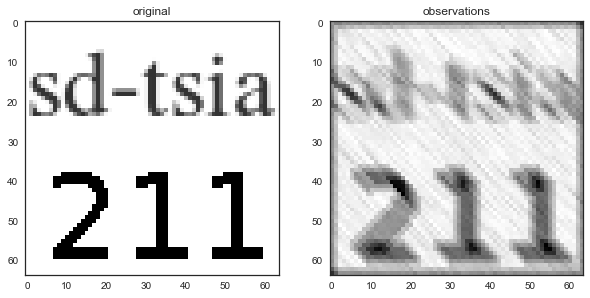

In [4]:
original = data.get('original')
observations = data.get('observations')

with sns.axes_style("white"):
    f, axarr = plt.subplots(1, 2, figsize=(10, 5))
    axarr[0].imshow(original, cmap=cm.gray)
    axarr[0].set_title('original')

    axarr[1].imshow(observations, cmap=cm.gray)
    axarr[1].set_title('observations')

# 2 Restauration d'image

## 2.1 Formulation du problème de restauration comme un problème d'optimisation sous contrainte

Le problème de restauration d'image est un problème mal posé, il faut donc avoir recours à une régularisation de la solution. Dans ce TP nous allons introduire deux termes de régularisation : une régularisation de type variation totale anisotrope et une contrainte de positivité puisque l'on mesure des intensités (grandeurs homogènes à des énergies, donc positives). On obtient alors le problème suivant :

$$ 
\begin{equation}
min_x \frac{1}{2} \| y - \mathbf{H}x \|^2_2 + \beta \| Tx \|_1 + \imath_{[0, 1]^P} (x) 
\end{equation}
$$

où $ \imath_{[0,1]^P}(x)$ traduit la contrainte que les pixels de l'image $x$ à reconstruire ont une valeur entre 0 et 1. S'il existe un élément $x_i < 0$ ou un élément $x_i > 1$ dans le vecteur $x$ alors $\imath_{[0,1]^P}(x) = +\inf$ , sinon, si tous les éléments de x sont dans [0, 1] , $ \imath_{[0,1]^P}(x) = 0 $. La matrice $T$ code la variation totale définie par :

$$
\begin{equation}
\| Tx \|_1 = \sum_{i, j} \big( \big| X[i+1, j] - X[i, j] \big| + \big| X[i, j+1] - X[i, j] \big| \big)
\end{equation}
$$

La matrice $T$ est rectangulaire, $T \in R^{(2P −K−L) \times P} , elle contient des coeffcients égaux à -1, 0 et 1 pour coder les décalages horizontaux et verticaux. Cette matrice est fournie dans le fichier "data2018.pk"

## 2.2 Algorithme ADMM

L'algorithme ADMM permet de minimiser la somme de deux fonctions convexes $f + g$ par duplication de la variable x (ou d'une transformée de x ) que l'on cherche à estimer. On rappelle que l'algorithme
ADMM permet de résoudre des problèmes de la forme :

$$
\begin{equation}
\begin{array}{ll@{}ll}
\displaystyle \min_{x}             & f(x) + g(z) \\ 
\text{subject to}: & Ax = z
\end{array}
\end{equation}
$$

où $g(z)$ résume les contraintes sur $x$ et la variable $z$ permet de dupliquer $x$ (ou une transformée de $x$ ).

## Préparation 1
---
Le problème de restauration d'image (3) contient une contrainte sur l'image $x$ à reconstruire : $\imath_{[0,1]^P}(x)$ et une pénalisation sur $Tx$ . En introduisant les variables $z_1 = x$ et $z_2 = Tx$ avec $z = [z^T_1 , z^T_2 ]^T$ , montrer que le problème de restauration d'image (3) peut s'écrire sous la forme (5).

Exprimer alors les fonctions $f$ et $g$ , le vecteur $z$ et la matrice $A$ .

---

## Réponse 1

$$ 
min_x \frac{1}{2} \| y - \mathbf{H}x \|^2_2 + \beta \| Tx \|_1 + \imath_{[0, 1]^P} (x) 
$$

$$
\begin{split}
z_1 & = x \\ 
z_2 & = Tx \\ 
z & = [z_1^T, z_2^T]^T = \begin{bmatrix} z_1 \\ z_2 \\ \end{bmatrix} =  \begin{bmatrix} x \\ Tx \\ \end{bmatrix} \\
f(x) & = \frac{1}{2} \| y - \mathbf{H}x \|^2_2 \\
g(z) & = \beta \| z_2 \|_1 + \imath_{[0, 1]^P}(z_1) \\
Ax & = \begin{bmatrix} I \\ T \\ \end{bmatrix} x = z
\end{split}
$$

L'ADMM consiste à minimiser le Lagrangien augmenté du problème (5) en fonction des variables $x$ et $z$ successivement. Le Lagrangien augmenté associé au problème (5) s'écrit :

$$
\begin{equation}
\mathcal{L}_{\rho} (x, z^k, \gamma^k) = f(x) + g(z) + \gamma^T(Ax-z) + \frac{\rho}{2} \| Ax - z \|^2_2
\end{equation}
$$

ou $\gamma$ est la variable duale (le multiplicateur de Lagrange). Dans notre cas $\gamma = [\gamma_1 , \gamma_2 ]^T$.

## Préparation 2

---

Ecrire le Lagrangien augmenté $\mathcal{L}_{\rho}$ du problème de restauration d'image (3).

---


## Réponse 2

$$
\begin{split}
\mathcal{L}_{\rho} (x, z^k, \gamma^k) &= f(x) + g(z) + \gamma^T(Ax-z) + \frac{\rho}{2} \| Ax - z \|^2_2 \\
 & = \frac{1}{2} \| y - \mathbf{H}x \|^2_2 + \beta \| z_2 \|_1 + \imath_{[0, 1]^P}(z_1) + \gamma^T(Ax - z) + \frac{\rho}{2}\|Ax-z\|^2_2 \\
\gamma^T(Ax - z) & = \begin{bmatrix} \gamma_1 \\ \gamma_2 \end{bmatrix}^T \left(\begin{bmatrix} I \\ T \end{bmatrix} x - \begin{bmatrix} z_1 \\ z_2 \end{bmatrix} \right) = \gamma_1^T (x-z_1) + \gamma_2^T(Tx-z_2)\\
\frac{\rho}{2}\|Ax-z\|^2_2 &=  \frac{\rho}{2} ( \|x-z_1\|^2_2 + \|Tx-z_2\|^2_2)
\end{split}
$$

L'ADMM est un algorithme itératif permettant de mettre à jour successivement les variables $x$ , $z$ et $\gamma$ .
A l'itération $k + 1$ :

$$
\begin{align}
x^{k+1} &= argmin_x \mathcal(L)_{\rho}(x, z^k, \gamma^k) \\ \nonumber
z^{k+1} &= [z_1^{k+1^T}, z_2^{k+1^T}] ^T \\ 
        &= argmin_x \mathcal(L)_{\rho}(x^{k+1}, z, \gamma^k) \\
\gamma^{k+1} &= \gamma^k + \rho (Ax^{k+1} - z^{k+1})
\end{align}
$$

## Préparation 3

---

Ecrire l'étape de minimisation de $L_\rho$ selon la variable $x$.

----

## Réponse 3

## x - update

$$
\require{cancel}
\begin{split}
x^{k+1} & = arg\min_x \frac{1}{2} \| y - \mathbf{H}x \|^2_2 + \cancel{g(z^k)} + (\gamma^k)^T(Ax - z^k) + \frac{\rho}{2}\|Ax-z^k\|^2_2\\
\frac{\partial \mathcal{L}_\rho}{\partial x} &= \mathbf{H}^T (\mathbf{H}x - y) + ((\gamma^k)^TA)^T = \rho A^T(Ax - z^k)\\
& = \mathbf{H}^T\mathbf{H}x + \rho A^TAx - H^Ty +  ((\gamma^k)^TA)^T -\rho A^T z^k = 0\\
x & = (\mathbf{H}^T\mathbf{H} + \rho A^TA))^{-1}(H^Ty - ((\gamma^k)^TA)^T +\rho A^T z^k)
\end{split}
$$

Pour éviter d'invertir la matrice on va résoudre le système:
$$
Bx = b 
$$
ou 
$$
\begin{split}
B & = (\mathbf{H}^T\mathbf{H} + \rho A^TA)) \\
b & = (H^Ty - ((\gamma^k)^TA)^T +\rho A^T z^k) \\
\end{split}
$$

## Préparation 4

---
Ecrire l'étape de minimisation de $L_\rho$ selon la variable $z_1$ .

Ecrire l'étape de minimisation de $L_\rho$ selon la variable $z_2$ .

---

## Réponse 4

## z - update

L'idée est de remarquer le carré plein et retrouver l'operateur proximal.

$$
\begin{split}
z^{k+1} &= arg\min_z \mathcal{L}_{\rho} (x^{k+1}, z, \gamma^k) = arg\min_z \cancel{f(x^{k+1})} + g(z) + (\gamma^k)^T(Ax^{k+1}-z) + \frac{\rho}{2} \| Ax^{k+1} - z \|^2_2 \\
 &= arg\min_z \beta \| z_2 \|_1 + \imath_{[0, 1]^P}(z_1) + (\gamma_1^k)^T (x^{k+1}-z_1) + (\gamma_2^k)^T(Tx^{k+1}-z_2) + \frac{\rho}{2} ( \|x^{k+1}-z_1\|^2_2 + \|Tx^{k+1}-z_2\|^2_2) \\ 
 & = arg\min_z  \imath_{[0, 1]^P}(z_1) + (\gamma_1^k)^T (x^{k+1}-z_1) + \frac{\rho}{2}\|x^{k+1}-z_1\|^2_2  \\
 & \quad \quad \quad \quad + \beta \| z_2 \|_1 + (\gamma_2^k)^T(Tx^{k+1}-z_2) + \frac{\rho}{2}\|Tx^{k+1}-z_2\|^2_2)\\
 & = arg\min_{z_1} g_1(z_1) + arg\min_{z_2} g_2(z_2) \\
z_1^{k+1} & = arg\min_{z_1} \imath_{[0, 1]^P}(z_1) - (\gamma_1^k)^T z_1 + \frac{\rho}{2}\|x^{k+1}-z_1\|^2_2 \\
& = arg\min_{z_1} \imath_{[0, 1]^P}(z_1) + \frac{\rho}{2} \left( ( \cancel{x^{k+1})^Tx^{k+1}}-2z_1^Tx^{k+1} + z_1^Tz_1 - \frac{2}{\rho} (\gamma_1^k)^T z_1 \right) \\
& = arg\min_{z_1} \imath_{[0, 1]^P}(z_1) + \frac{\rho}{2}\| z_1 - (x^{k+1} + \frac{1}{\rho} \gamma_1^k) \|^2_2 \\
& = prox_{\rho^{-1}\imath_{[0, 1]^P}(z_1)}(x^{k+1} + \frac{1}{\rho} \gamma_1^k) \\
\\
z_2^{k+1} & = arg\min_{z_2} \beta \| z_2 \|_1 + (\gamma_2^k)^T(Tx^{k+1}-z_2) + \frac{\rho}{2}\|Tx^{k+1}-z_2\|^2_2) \\
& = arg\min_{z_2} \beta \| z_2 \|_1 + \frac{\rho}{2} \left( ( \cancel{Tx^{k+1})^TTx^{k+1}}-2z_2^TTx^{k+1} + z_2^Tz_2 - \frac{2}{\rho} (\gamma_2^k)^T z_2 \right) \\
& = arg\min_{z_2} \beta \| z_2 \|_1 + \frac{\rho}{2} \| z_2 - (Tx^{k+1} + \frac{1}{\rho}\gamma_2^k) \|^2_2 \\
& = prox_{\beta \rho^{-1} \| z_2 \|_1}(Tx^{k+1} + \frac{1}{\rho} \gamma_2^k) \\
\\
\end{split}
$$



## Préparation 5

---

Ecrire l'étape (9) de mise à jour des variables duales $\gamma_1$ et $\gamma_2$ .

---

## Réponse 5

## $\gamma$ - update

$$
\begin{split}
\gamma^{k+1} &= \gamma^k + \rho \left( \begin{bmatrix} I \\ T \end{bmatrix} x^{k+1} - \begin{bmatrix} z^{k+1}_1 \\ z^{k+1}_2 \end{bmatrix} \right) \\
\\
\gamma^{k+1}_1 &= \gamma^k_1 + \rho (x^{k+1} - z_1^{k+1})\\
\gamma^{k+1}_2 &= \gamma^k_2 + \rho (Tx^{k+1} - z_2^{k+1}) \\
\end{split}
$$



# 3 Implémentation de l'ADMM pour résoudre le problème de restauration d'image

Nous allons maintenant implémenter l'algorithme ADMM pour restaurer l'image floue contenue dans le fichier data2018.pk . Dans un premier temps, on fixera les différents paramètres de l'ADMM aux valeurs
suivantes :

- $\rho$ = 0.01,
- $\beta$ = 0.01,
- $k_{max}$ = 100.

## Manipulation 2

---

A partir des équations développées dans la section précédente, écrire un script python permettant de résoudre le problème (3) à l'aide de l'ADMM.

On rappelle que la vectorisation d'une image de taille K × L en python s'effectue de la façon suivante :

```python
K,L = im.shape
vec = numpy.reshape(im, K*L)
ou
vec = numpy.ravel()
```
Pour la résolution des systèmes linéaires avec une matrice définie positive et creuse, il peut être intéressant
d'utiliser la méthode du gradient conjugué implémentée dans **scipy.sparse.linalg.cg**.

---

L'ADMM minimise le Lagrangien augmenté associé au problème de restauration d'image (3). Afin de caractériser la qualité de la restauration, on peut s'intéresser à l'erreur quadratique moyenne à l'itération k :

$$
\begin{equation}
EQM^k = \frac{1}{P}\sum_{p=1}^P (x^k - x)^2
\end{equation}
$$

où x est l'image originale. On s'intéresse aussi au biais $B(x^k)$ :

$$
\begin{equation}
B(x^k) = x^k - x
\end{equation}
$$


In [5]:
def l1_prox(x, alpha):
    n = x.shape[0]
    result = np.zeros(n)
    for i in range(n):
        if x[i] < -alpha:
            result[i] = x[i] + alpha
        elif x[i] > alpha:
            result[i] = x[i] - alpha

    return result


def indicator_prox(x, amin, amax, gamma):
    return np.clip(x, a_min=amin, a_max=amax)


def indicator(x, amin, amax):
    for x_i in x:
        if not (amin <= x_i <= amax):
            return np.inf
    return 0


def EQM_callback(x, x_real):
    return np.mean((x - x_real)**2)


def B_callback(x, x_real):
    return x - x_real

In [6]:
def admm(y,
         H,
         T,
         rho,
         beta,
         max_iter,
         trace=False,
         display=True,
         callbacks=None):
    """
    admm for image restauration
    
    Parameters
    ----------
    y : array
        distorted vectorized image
    H : array
        martix that represents distortion filter
    T : array
        matrix for total variation difference scheme
    rho: double 
        smoothing coefficient
    beta : double
        total variance regularization coefficient
    max_iter: int
        maximal number of iteration of admm
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        
    callbacks: dict{list}
        dictionary of callable f(x) to track some progress
    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
        
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['Lp'] : list of augmented lagrangians 
            
    """
    start_time = datetime.now()
    history = defaultdict(list) if trace else None

    p = len(y)
    m = T.shape[0]

    # initialize
    I = scipy.sparse.eye(p)
    A = scipy.sparse.vstack([I, T])

    gamma_1 = np.random.rand(p, 1)
    gamma_2 = np.random.rand(m, 1)
    gamma = np.vstack([gamma_1, gamma_2])

    z_1 = np.random.rand(p, 1)
    z_2 = np.random.rand(m, 1)
    z = np.vstack([z_1, z_2])

    def augmented_lagrangian(x, z, gamma, A, H, T, rho, beta):
        f = 0.5 * np.linalg.norm(y - H.dot(x))**2
        g = beta * np.linalg.norm(T.dot(x), ord=1) + indicator(x, 0, 1)
        reg = gamma.T.dot(A.dot(x) - z)
        reg += 0.5 * rho * np.linalg.norm(A.dot(x) - z)**2
        return float(f + g + reg)

    Lp = partial(augmented_lagrangian, A=A, H=H, T=T, rho=rho, beta=beta)

    for k in range(max_iter):
        # x-update
        B = H.T.dot(H) + rho * A.T.dot(A)
        b = H.T.dot(y) - A.T.dot(gamma) + rho * A.T.dot(z)
        x, _ = scipy.sparse.linalg.cg(B, b)
        x = x.reshape([-1, 1])

        # z-updated
        z_1 = indicator_prox(x + gamma_1 / rho, 0, 1, 1 / rho)
        z_2 = l1_prox(T.dot(x) + gamma_2 / rho, beta / rho)
        z_2 = z_2.reshape([-1, 1])
        z = np.vstack([z_1, z_2])

        # gamma - update
        gamma_1 = gamma_1 + rho * (x - z_1)
        gamma_2 = gamma_2 + rho * (T.dot(x) - z_2)
        gamma = np.vstack([gamma_1, gamma_2])

        if trace:
            history['time'].append(
                (datetime.now() - start_time).total_seconds())
            history['Lp'].append(Lp(x, z, gamma))
            if callbacks:
                for key, callback in callbacks.items():
                    history[key].append(callback(x))

        if display:
            print('iteration: %d/%d' % (k, max_iter))

    return x, history

## Manipulation 3

---

Evaluer à chaque itération la valeur du Lagrangien augmenté et de l'erreur quadratique moyenne. Commenter les courbes obtenues. Afficher le biais obtenu pour l'estimation finale.

---

In [7]:
original = data.get('original')
observations = data.get('observations')

K, L = original.shape

x = np.reshape(original, [K * L, 1])
y = np.reshape(observations, [K * L, 1])

callbacks = {
    'EQM': lambda xk: EQM_callback(xk, x),
    'Bias': lambda xk: B_callback(xk, x)
}

# filter
H = data.get('H')
# Total variation
T = data.get('T')

rho = 0.01
beta = 0.1
k_max = 100

In [8]:
%%time
x_restored, history = admm(
    y,
    H,
    T,
    rho,
    beta,
    max_iter=k_max,
    trace=True,
    display=False,
    callbacks=callbacks)

CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 2.98 s


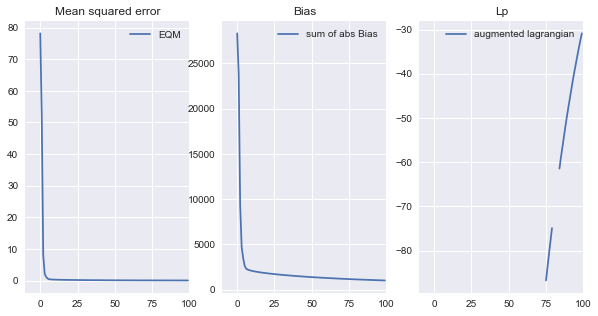

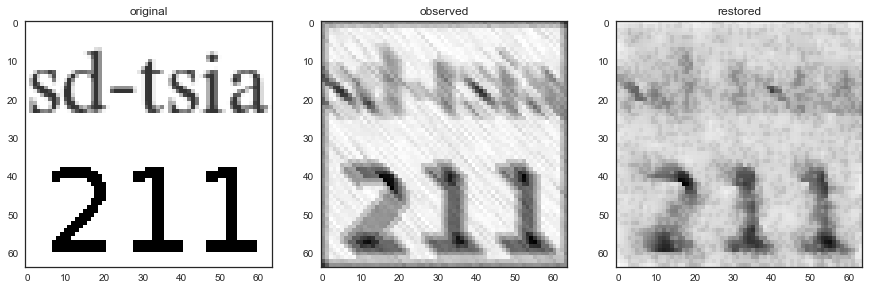

In [9]:
f, axarr = plt.subplots(1, 3, figsize=(10, 5))
axarr[0].plot(history['EQM'], label='EQM')
axarr[0].legend()
axarr[0].set_title('Mean squared error')

axarr[1].plot(
    [np.sum(abs(x)) for x in history['Bias']], label='sum of abs Bias')
axarr[1].legend()
axarr[1].set_title('Bias')

axarr[2].plot(history['Lp'], label='augmented lagrangian')
axarr[2].legend()
axarr[2].set_title('Lp')

for ax in axarr:
    #   ax.set_ylim(bottom=0, top=200)
    ax.set_xlim(left=-10, right=100)
plt.show()

with sns.axes_style("white"):
    f, axarr = plt.subplots(1, 3, figsize=(15, 5))
    axarr[0].imshow(original, cmap=cm.gray)
    axarr[0].set_title('original')

    axarr[1].imshow(observations, cmap=cm.gray)
    axarr[1].set_title('observed')

    axarr[2].imshow(x_restored.reshape([K, L]), cmap=cm.gray)
    axarr[2].set_title('restored')

    plt.show()

## Commentaires sur les courbes

La méthode est convergée assez vite.

On peut remarquer que la méthode a réussi à restaurer un peu les chiffres

## Manipulation 4

---

Faire varier le paramètre $\rho$ dans l'intervalle $[10^{−4} , 1]$ et $\beta$ dans $[10^{−5} , 1]$ .

Analyser l'influence de chacun de ces paramètres sur la solution (qualité de la reconstruction, biais, EQM, etc) et sur le problème d'optimisation (convergence, rapidité, etc).

---

In [10]:
beta_values = np.logspace(start=-5, stop=0, num=6, base=10, endpoint=True)
rho_values = np.logspace(start=-4, stop=0, num=5, base=10, endpoint=True)

In [11]:
%%time
results = {}
k_max = 100

for beta in beta_values:
    results[beta] = {}
    for rho in rho_values:
        x_restored, history = admm(
            y,
            H,
            T,
            rho,
            beta,
            max_iter=k_max,
            trace=True,
            display=False,
            callbacks=callbacks)
        results[beta][rho] = (x_restored, history)

CPU times: user 2min 19s, sys: 159 ms, total: 2min 19s
Wall time: 2min 19s


## Commentaires sur la qualité de la reconstruction

les meilleurs résultats donnent les paramètres suivants:

$ \beta = [10^{-5}, 10^{-3}]$ et $ \rho = [0.1, 1] $

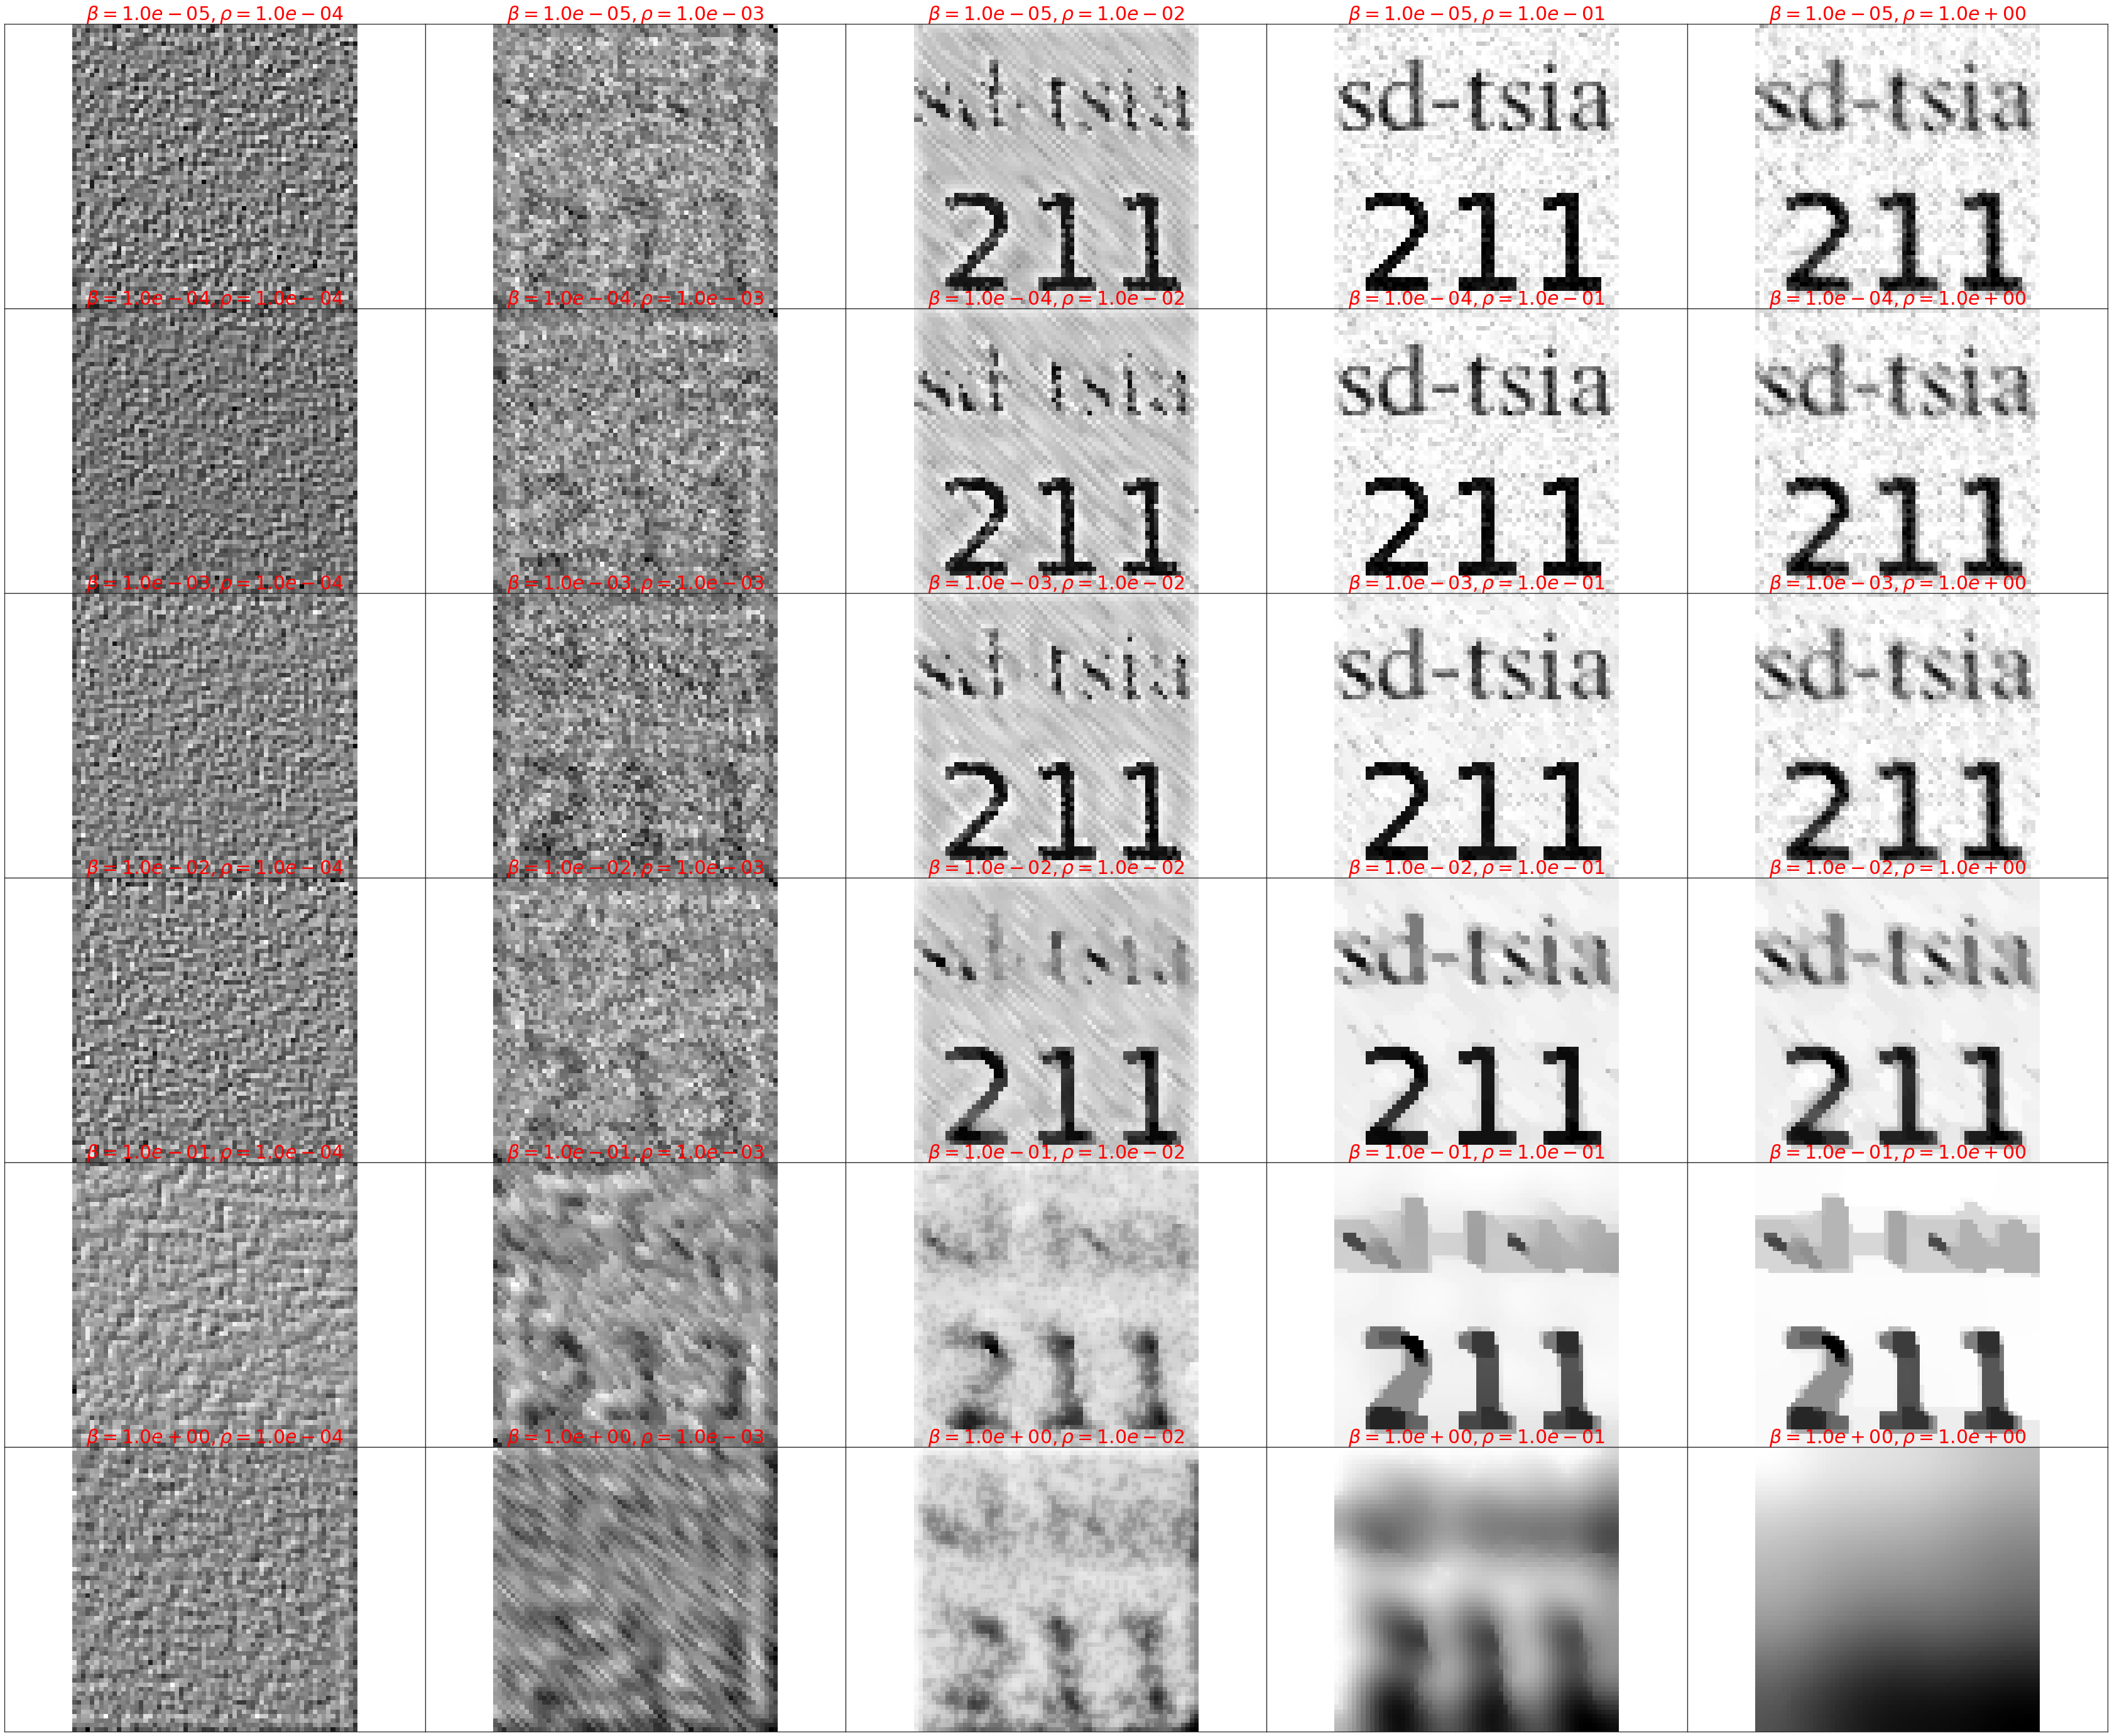

In [12]:
# plot recostructed images
n = len(beta_values)
m = len(rho_values)

with sns.axes_style("white"):
    f, axarr = plt.subplots(
        nrows=n, ncols=m, figsize=(10 * n, 10 * m), sharex=True, sharey=True)

    for i, beta in enumerate(beta_values):
        for j, rho in enumerate(rho_values):
            x_restored = results[beta][rho][0]
            axarr[i, j].imshow(x_restored.reshape([K, L]), cmap=cm.gray)
            axarr[i, j].set_title(
                r'$\beta = %.1e, \rho = %.1e$' % (beta, rho),
                size=30,
                color='red')

    for arr in axarr:
        for a in arr:
            a.set_xticklabels([])
            a.set_yticklabels([])
            a.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Commentaires sur la convergence

Si on augmente $\beta$ avec $\rho$ fixé EQM et converge plus vite.

Si on augmente $\rho$ avec $\beta$ fixé EQM et converge aussi plus vite. 

Mais l'influence de $\rho$ et plus forte. ( $\beta$ contrôle le smoothness/régularité d'image, $\rho$ - régularise la restauration )

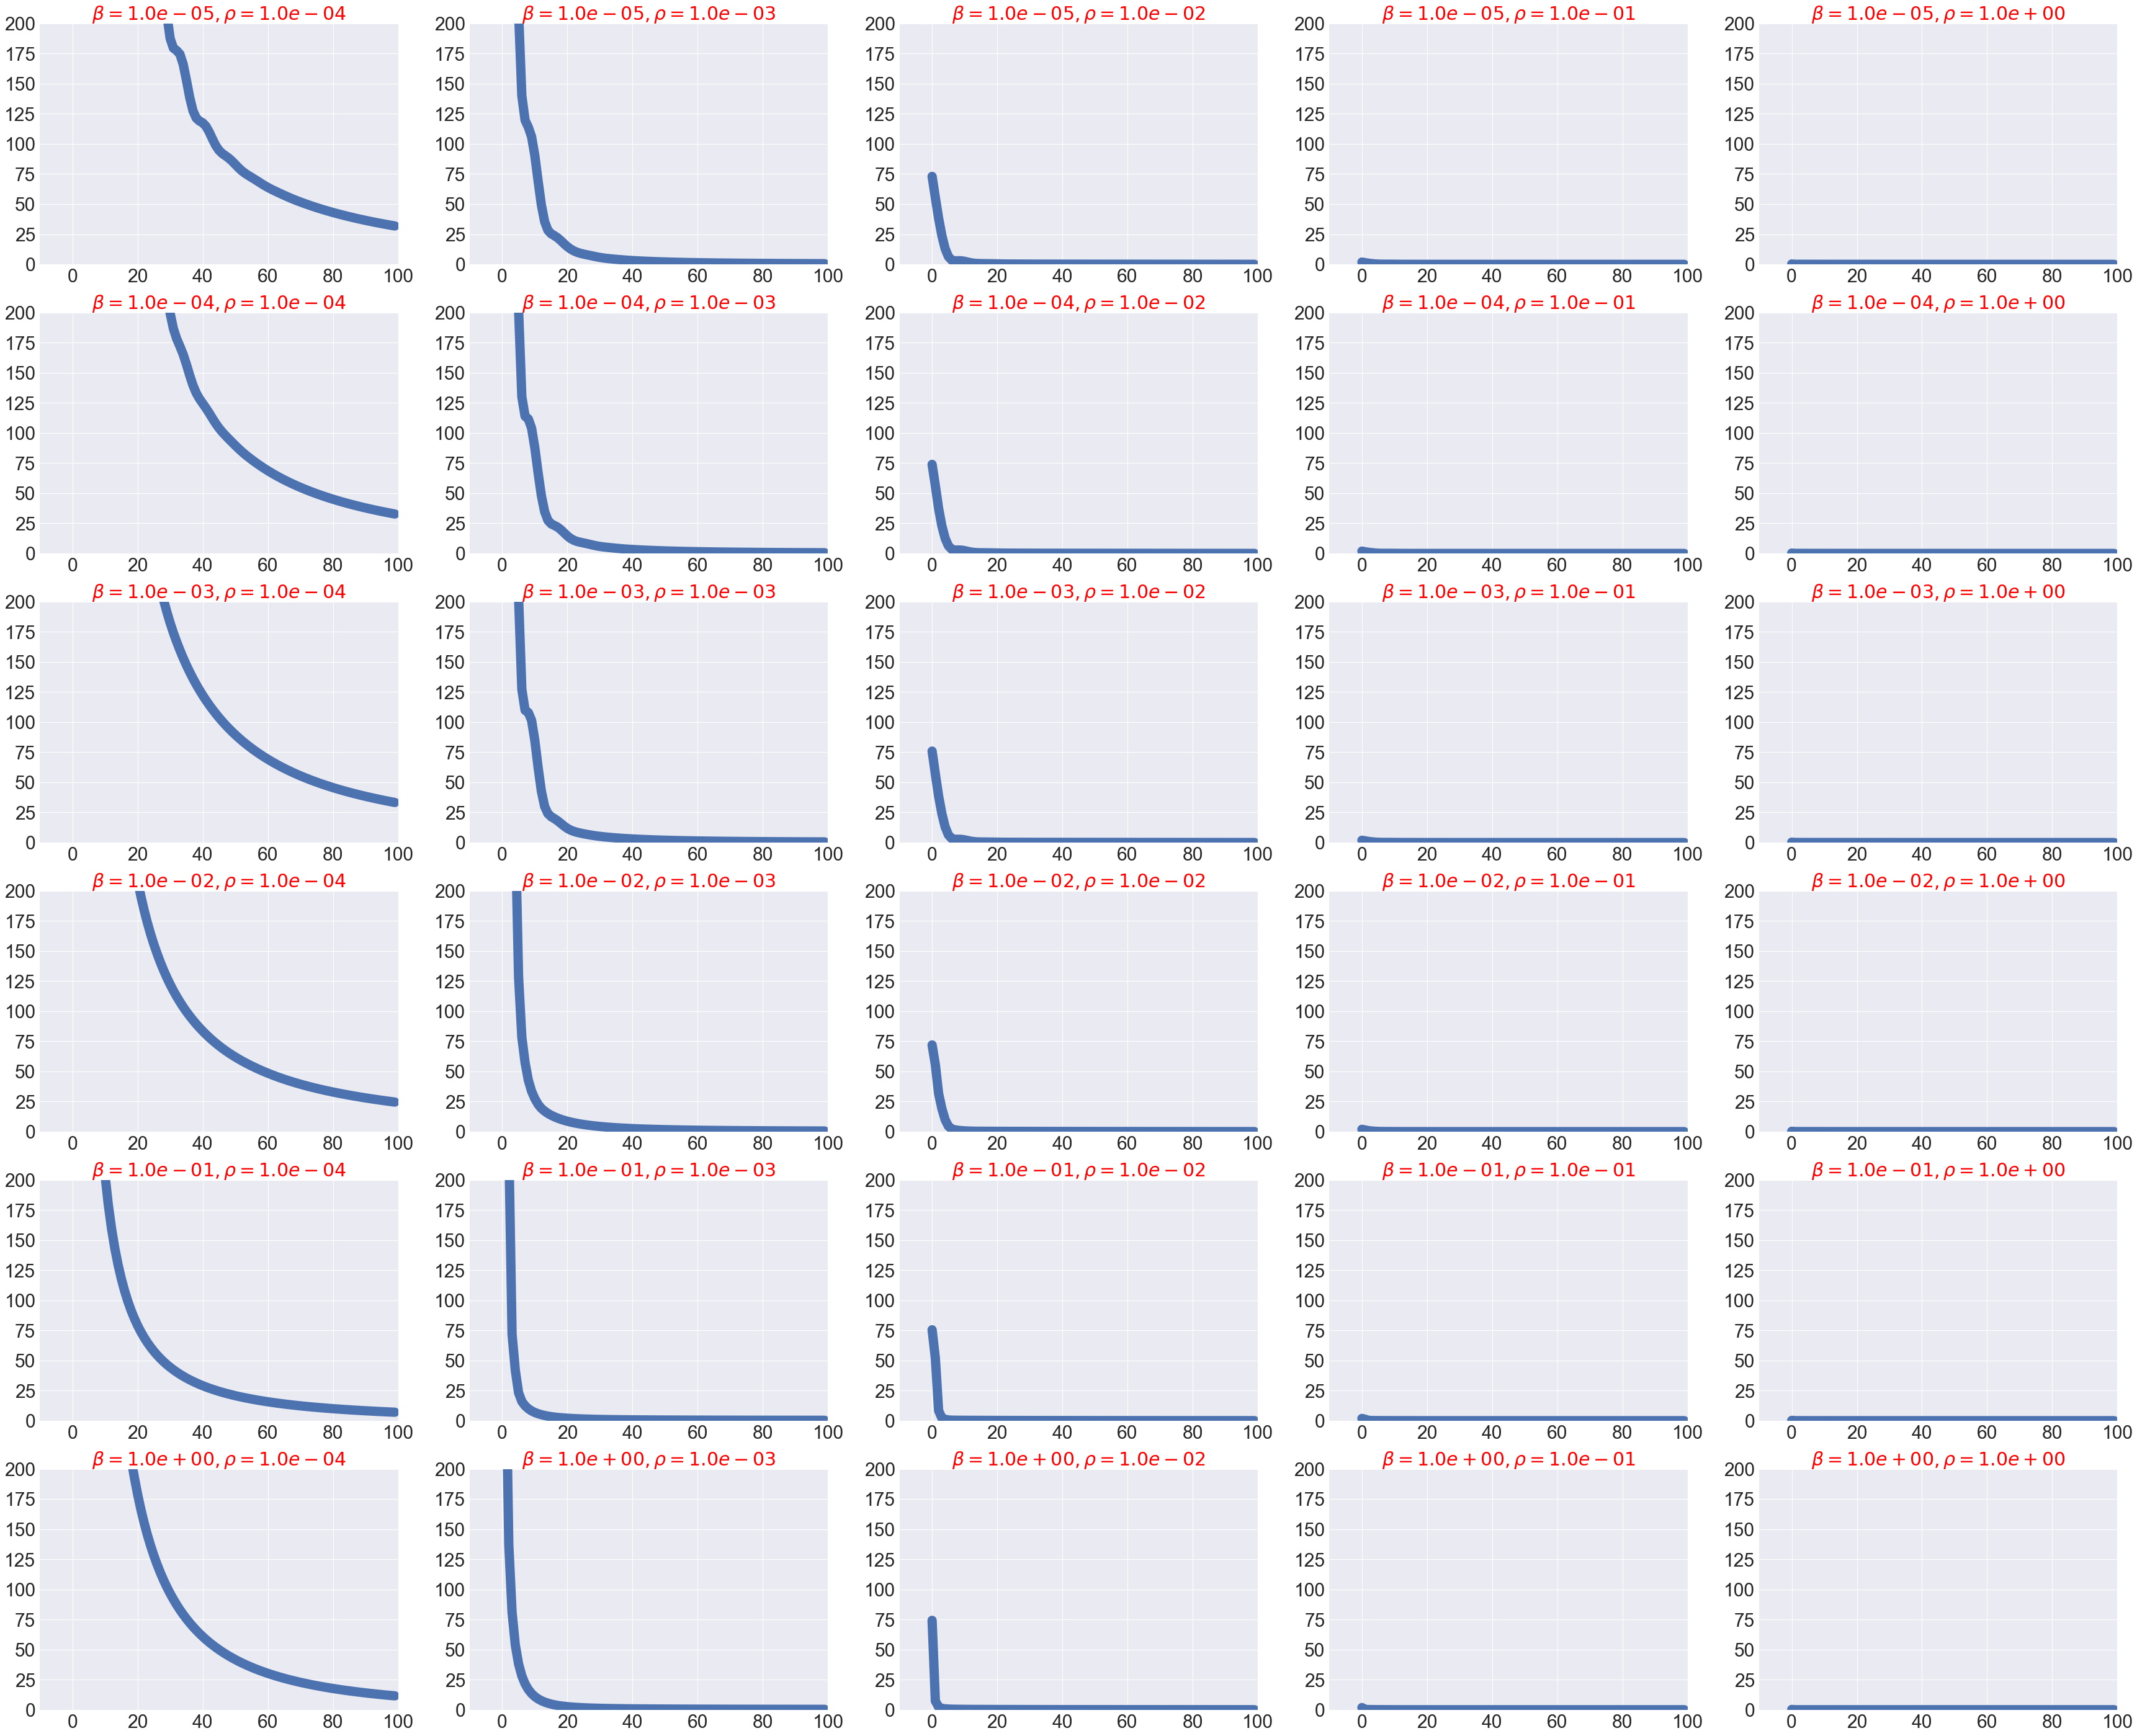

In [13]:
# plot EQM
n = len(beta_values)
m = len(rho_values)
f, axarr = plt.subplots(nrows=n, ncols=m, figsize=(10 * n, 10 * m))

for i, beta in enumerate(beta_values):
    for j, rho in enumerate(rho_values):
        history = results[beta][rho][1]
        axarr[i, j].plot(history['EQM'], linewidth=15.0)
        axarr[i, j].set_title(
            r'$\beta = %.1e, \rho = %.1e$' % (beta, rho), size=30, color='red')

for arr in axarr:
    for a in arr:
        #         a.set_xticklabels([])
        #         a.set_yticklabels([])
        #         a.set_aspect('equal')
        a.set_ylim(bottom=0, top=200)
        a.set_xlim(left=-10, right=100)
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in a.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

# plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

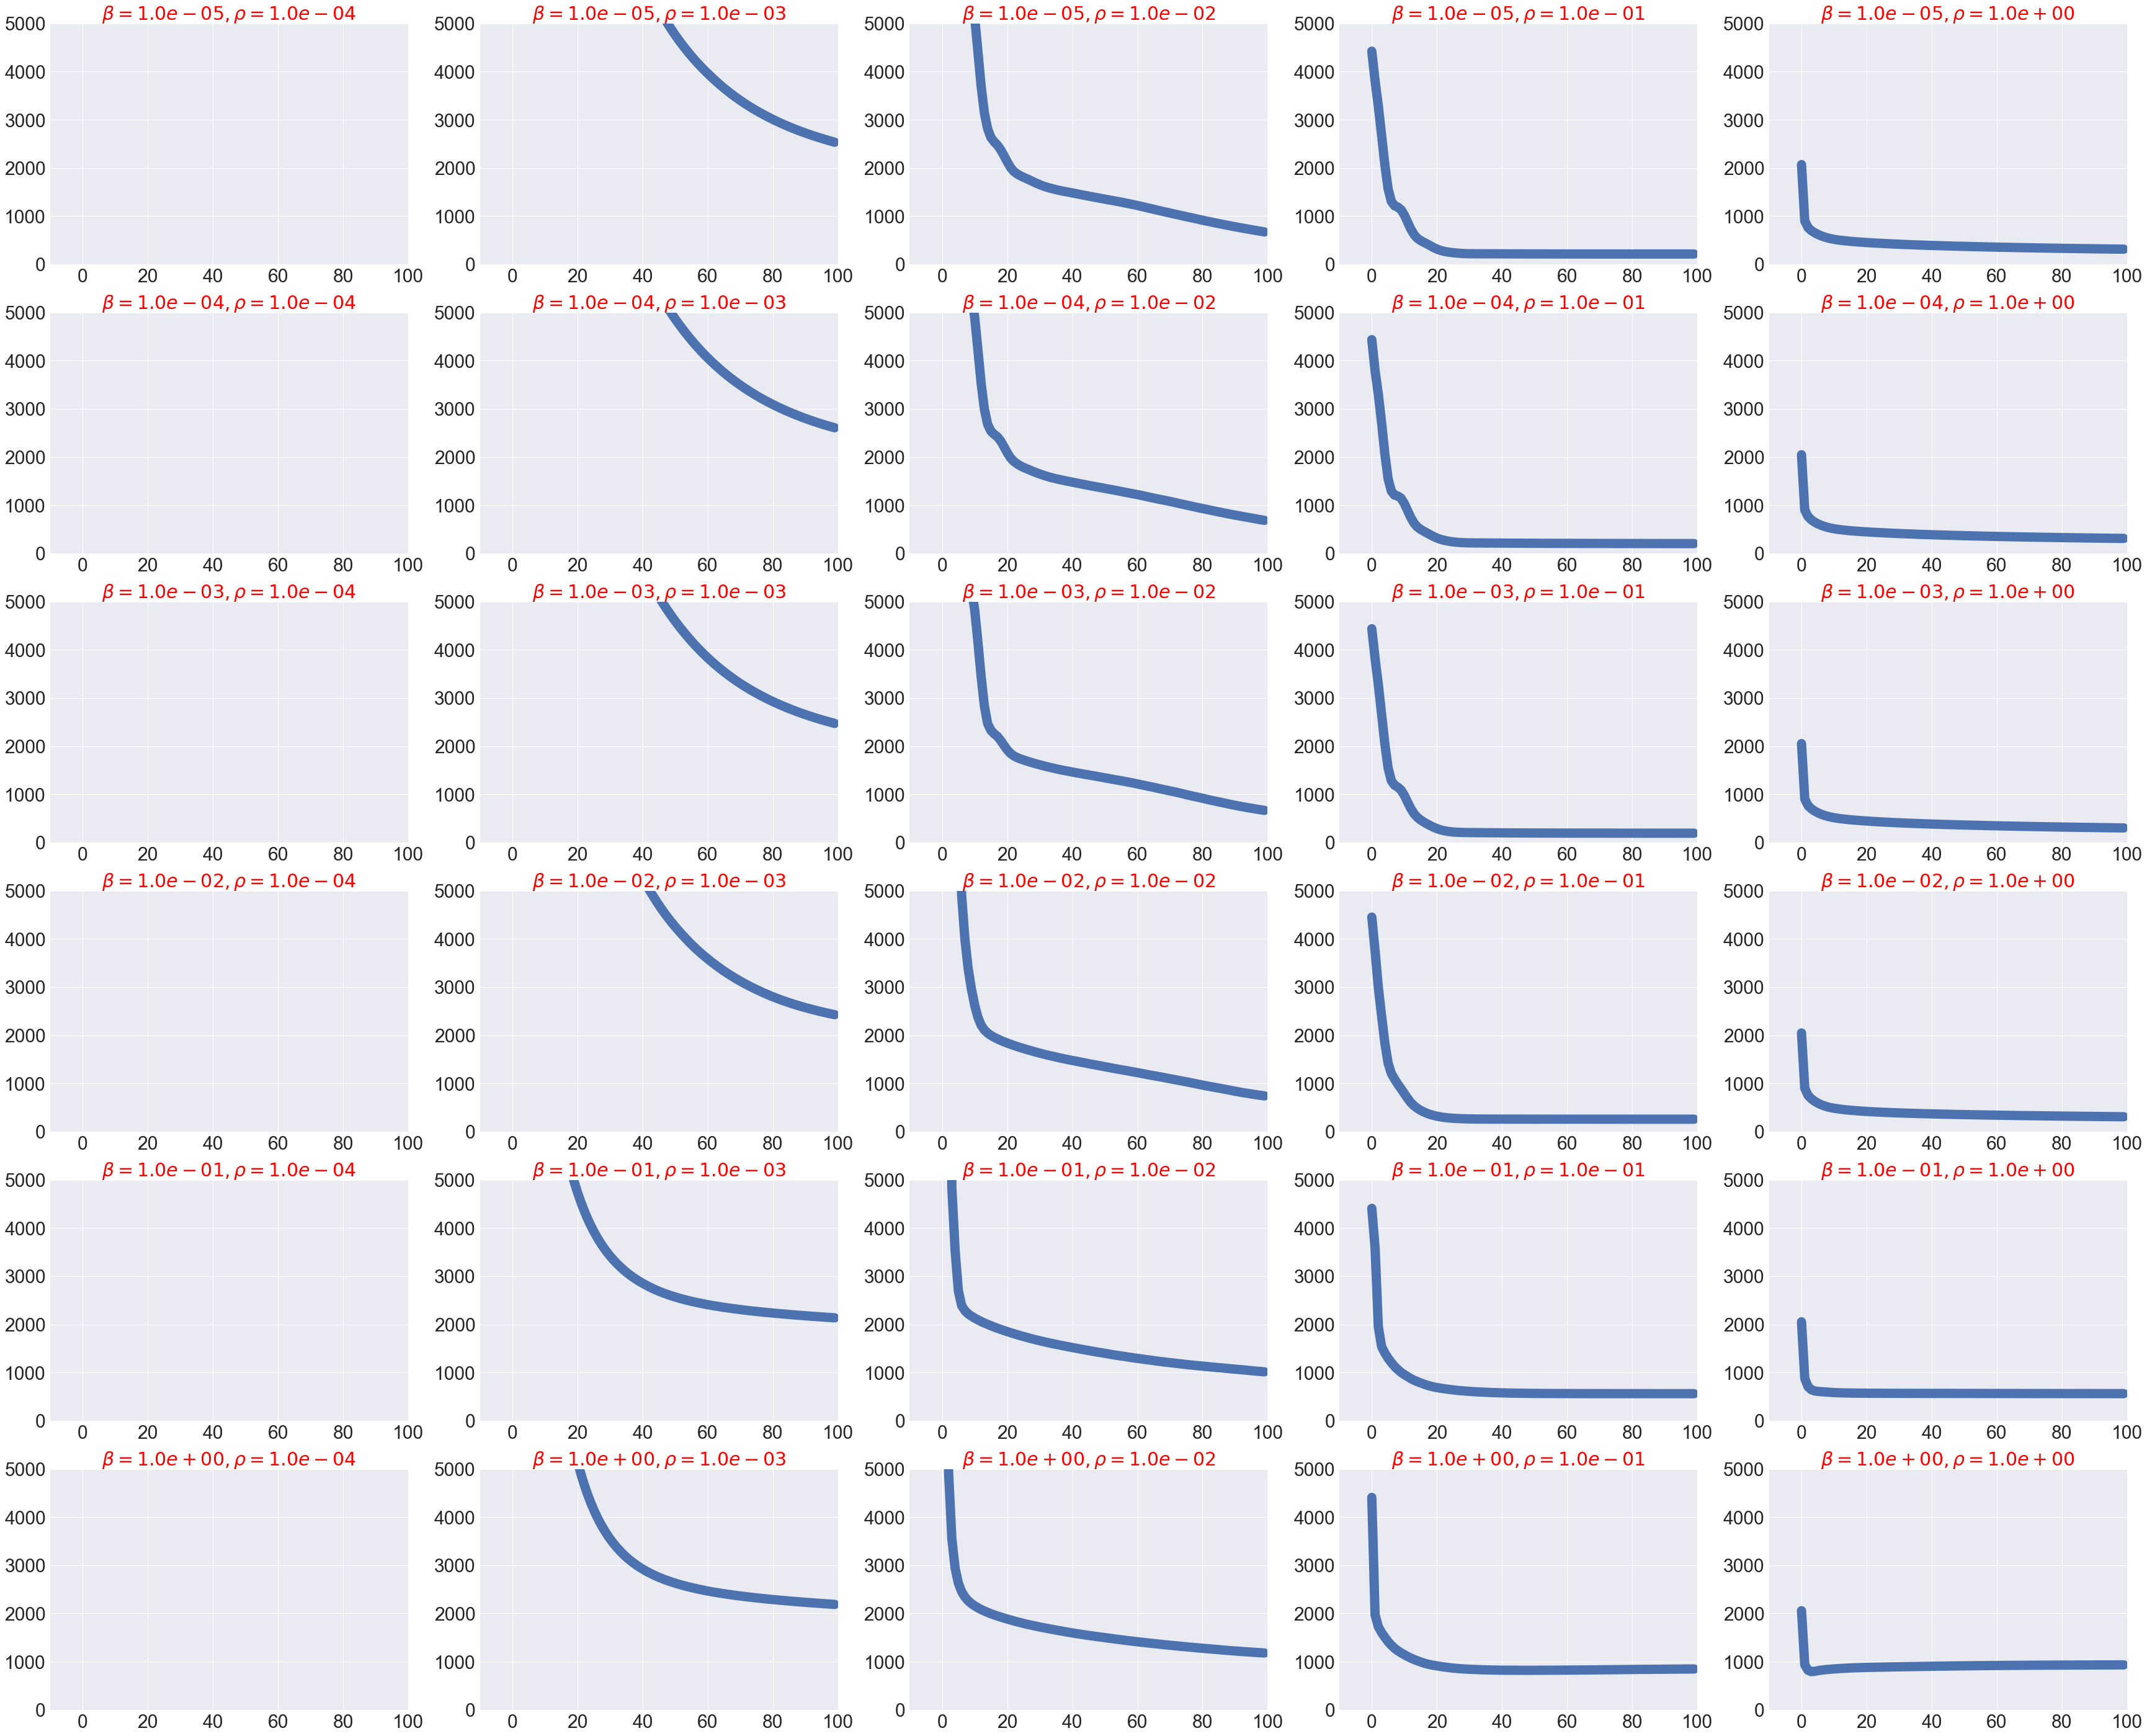

In [14]:
# plot bias
n = len(beta_values)
m = len(rho_values)
f, axarr = plt.subplots(nrows=n, ncols=m, figsize=(10 * n, 10 * m))

for i, beta in enumerate(beta_values):
    for j, rho in enumerate(rho_values):
        history = results[beta][rho][1]
        axarr[i, j].plot(
            [np.sum(abs(x)) for x in history['Bias']], linewidth=15.0)
        axarr[i, j].set_title(
            r'$\beta = %.1e, \rho = %.1e$' % (beta, rho), size=30, color='red')

for arr in axarr:
    for a in arr:
        #         a.set_xticklabels([])
        #         a.set_yticklabels([])
        #         a.set_aspect('equal')
        a.set_ylim(bottom=0, top=5000)
        a.set_xlim(left=-10, right=100)
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in a.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

# plt.subplots_adjust(wspace=0, hspace=0)
plt.show()